# Síntese da primeira semana para o experimento de Raio X

Grupo GD 18

## Introdução

Nesta semana iremos adquirir o espectro de emissão raio-x do Molibênio.

Busca-se observar tanto o fenômeno do efeito fotoelétrico quanto da transição de estados quânticos.

## Arranjo e procedimentos experimentais

### Arranjo Experimental

* Apararato de Raio X Rontgengerat 5544 800
* Cristal de Sódio
* Tubo de Mo

### Procedimentos

* Coloca-se o cristal de sódio dentro do aparato
* Abre-se o software X-Ray Apparatus
* Coloca-se os parâmetros de medidas: U, $\beta_{min}$, $\beta_{max}$, $\Delta \beta$, $\Delta t$ e I
* Marca-se o "Scan" e "HV"
* Após a finalização da aquisição do espectro de emissão, salva-se o arquivo

Foram feitas sete tomadas de dados, nas quais foram usadas os seguintes parâmetros:

<table>
    <tr><th>Tomada</th><th>Tensão (kV)</th><th>$\beta_{max}$ (º)</th><th>$\Delta t$ (s)</th><th>I (mA)</th></tr>
    <tr><td>#1</td><td>35</td><td>30</td><td>1</td><td>1.0</td></tr>
    <tr><td>#2</td><td>27</td><td>12</td><td>2</td><td>1.0</td></tr>
    <tr><td>#3</td><td>22</td><td>12</td><td>2</td><td>1.0</td></tr>
    <tr><td>#4</td><td>35</td><td>12</td><td>2</td><td>1.0</td></tr>
    <tr><td>#5</td><td>35</td><td>12</td><td>2</td><td>0.8</td></tr>
    <tr><td>#6</td><td>35</td><td>12</td><td>2</td><td>0.6</td></tr>
    <tr><td>#7</td><td>35</td><td>12</td><td>2</td><td>0.4</td></tr>
</table>

## Resultados

Feita as medições, converte-se os ângulos de $\beta$ para energias utilizando-se da fórmula $E=\frac{hc}{2d\sin{\beta}}$. A incerteza associada a cada intensidade é a raíz quadrada desta última, devido as medições em estarem associadas a uma distribuição de Poisson

### Parte 1 - variação na tensão com I = 1.0mA

In [31]:
# Dependências

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.constants as ctes
import scipy.signal as sig
import scipy.stats as st
import uncertainties as unc
matplotlib.rcParams['figure.figsize'] = (15, 6)

In [32]:
# Definições, parâmetros e constantes

data_folder = "Sem1"
filepath = os.path.join(data_folder, "sem1_18kv.xry")
columns = ["35kV", "27kV", "22kV", "18kV"]
beta_min = 2.5 # deg
beta_max = 30 # deg
delta_beta = 0.1 # deg
d = 0.282 * 1e-9 # m
beta = np.arange(beta_min, beta_max + delta_beta, delta_beta)
beta_rad = np.radians(beta)
h = ctes.Planck
c = ctes.speed_of_light
e = ctes.eV
I = h * c / (2 * d * np.sin(beta_rad))

In [33]:
# Carregar os dados para a variação na tensao

data = pd.read_csv(filepath, skiprows=18, delimiter="\t", names=columns, index_col=False,
                   skipfooter=14, engine="python", na_values=["NAN"])
#data["beta"] = beta
data["I"] = I
data.index = data["I"]
data.drop("I", inplace=True, axis=1)

U: 35kV	Lambda_min: 1.497073733230734e-38 m	Pico (keV) em 19.72+/-0.25, 17.54+/-0.20, 
U: 27kV	Lambda_min: 3.226327469263542e-38 m	Pico (keV) em 19.72+/-0.25, 17.54+/-0.20, 
U: 22kV	Lambda_min: 1.263111048133439e-37 m	Pico (keV) em 17.54+/-0.20, 
U: 18kV	Lambda_min: 4.1065379202065855e-37 m	Pico (keV) em 15.05+/-0.15, 13.90+/-0.12, 12.79+/-0.10, 


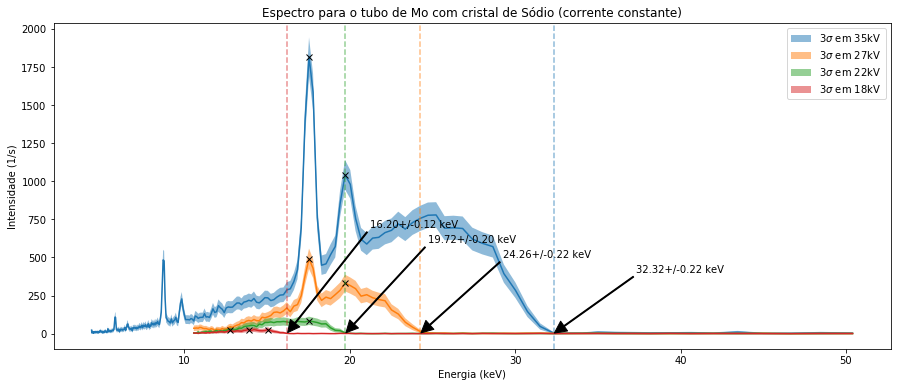

In [34]:
# Fazer o gráfico com incerteza para as medidas e detectar os picos

for i, U in enumerate(columns):
    U_data = data.loc[:, U].copy() 
    U_data = U_data[~pd.isnull(U_data)]
    U_data.index /= e * 1e3    
    peaks = sig.find_peaks(U_data, prominence=np.mean(U_data), height=np.max(U_data)/2)
    inds = peaks[0]
    neighbor1 = U_data.index[inds - 1]
    neighbor2 = U_data.index[inds + 1]
    L = np.abs(neighbor2 - neighbor1)
    err = L / (np.sqrt(6))

    
    far_peak = U_data.index[np.max(peaks[0])]
    col = U_data
    q = col.min() + col.quantile(0.25) * 4 / 5 + col.mean() / 5
    E_max_inds = U_data < q
    E_max_inds &= U_data.index > far_peak
    
    lamb_min = q
    
    E_max = U_data[E_max_inds].index.min()
    plt.axvline(E_max, linestyle="--", alpha=0.5, color="C{}".format(i))    
       
    
    E_max = unc.ufloat(E_max, np.mean(err))    
    lamb_min = h / (lamb_min * 1000)
    annotate_label = "{} keV".format(E_max, lamb_min)
    plt.annotate(annotate_label, xy=(E_max.n, 0),
                 xytext=(E_max.n + 5, 400 + 100 * i),
                 arrowprops=dict(facecolor='black', shrink=0.01, width=1))
    
    Uerr = 3 * np.sqrt(U_data.values)
    Uerr_less = U_data - Uerr
    Uerr_more = U_data + Uerr
    plt.plot(U_data, label="", color="C{}".format(i))
    plt.plot(U_data.iloc[inds], 'x', label="", color="k")
    plt.fill_between(U_data.index, Uerr_less, Uerr_more, alpha=0.5, label=r"$3 \sigma$ em " + U)
    texto = "U: {}\t".format(U)
    texto += "Lambda_min: {} m\t".format(lamb_min)
    texto += "Pico (keV) em "
    for i, peak in enumerate(U_data.iloc[inds].index):
        peak_val = unc.ufloat(peak, err[i])
        texto += "{:.2f}, ".format(peak_val)
    print(texto)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensidade (1/s)")
plt.title("Espectro para o tubo de Mo com cristal de Sódio (corrente constante)")
plt.legend()
plt.show()

#### Comentários

No gráfico acima tem-se as diferentes contagens de fótons para os diferentes potenciais de aceleração. As setas indicam a energia máxima dos fótons emitidos pelo Molibênio e os 'x' marcam os picos encontrados. Para os dois valores mais altos de energia, a energia máxima é compatível com o valor esperado ( potencial de aceleração - 2,867), o que não ocorre com os outros valores.

Percebe-se que há dois picos de absorção: em 19.72eV e 17.54eV (para n=1 na lei de Bragg). A incerteza associada a localização dos picos foi estimada calculando-se a variância esperada para uma distribuição uniforme para uma largura cujo tamanho são os dois pontos vizinhos aos picos.

Os picos aparecem nas curvas associadas com as duas tensões mais elevadas (35kV e 27kV). Na curva de 22kV detecta-se somente um dos pícos porém de forma quase indistinguível de rúido em relação a intensidade. Não se nota picos de absorção para a tensão de 18kV.

Feito isso, repete-se o processeo de análise para a tensão de 35kV visando obter as energias dos picos de emissão para as ordens n=2 e n=3.

U: 35kV. Pico (keV) em 19.69+/-0.12, 17.44+/-0.10, 


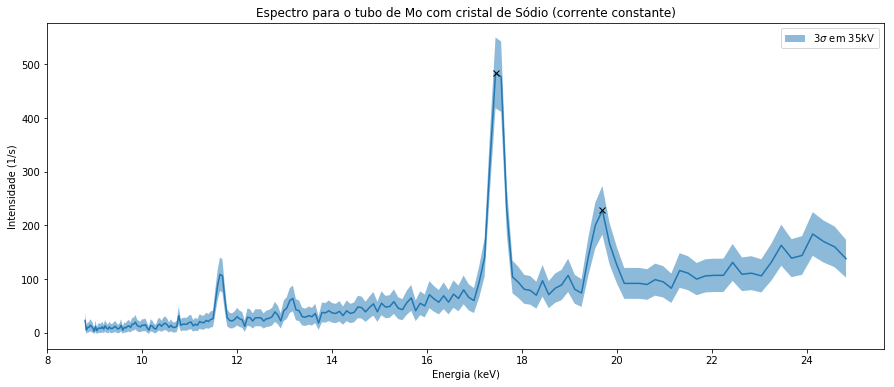

In [35]:
U = "35kV"
n = 2
U_data = data.loc[:, U].copy()    
U_data.index /= (e * 1e3)
U_data.index *= n
filter_inds = (U_data.index < 25)
U_data = U_data[filter_inds]
peaks = sig.find_peaks(U_data, prominence=np.mean(U_data), height=np.max(U_data)/4)
inds = peaks[0]
neighbor1 = U_data.index[inds - 1]
neighbor2 = U_data.index[inds + 1]
L = np.abs(neighbor2 - neighbor1)
err = L / (np.sqrt(6))
Uerr = 3 * np.sqrt(U_data.values)
Uerr_less = U_data - Uerr
Uerr_more = U_data + Uerr
plt.plot(U_data, label="")
plt.plot(U_data.iloc[inds], 'x', label="", color="k")
plt.fill_between(U_data.index, Uerr_less, Uerr_more, alpha=0.5, label=r"$3 \sigma$ em " + U)
texto = "U: {}. Pico (keV) em ".format(U)
for i, peak in enumerate(U_data.iloc[inds].index):
    peak_val = unc.ufloat(peak, err[i])
    texto += "{:.2f}, ".format(peak_val)
print(texto)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensidade (1/s)")
plt.title("Espectro para o tubo de Mo com cristal de Sódio (corrente constante)")
plt.legend()
plt.show()

U: 35kV. Pico (keV) em 19.76+/-0.08, 17.45+/-0.06, 


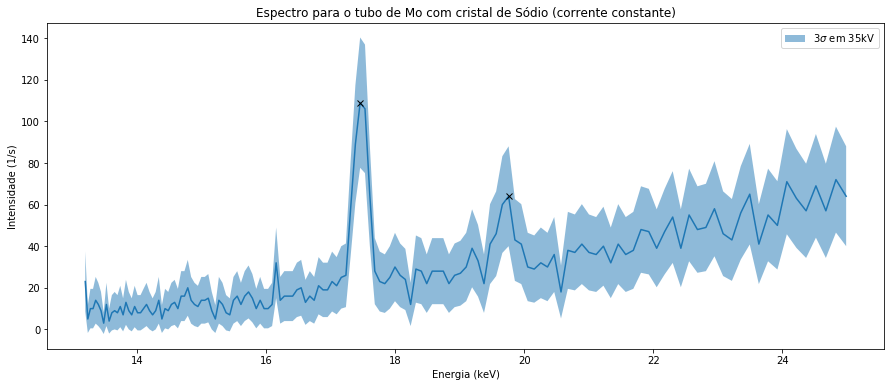

In [36]:
U = "35kV"
n = 3
U_data = data.loc[:, U].copy()    
U_data.index /= (e * 1e3)
U_data.index *= n
filter_inds = (U_data.index < 25)
U_data = U_data[filter_inds]
peaks = sig.find_peaks(U_data, prominence=np.mean(U_data), height=np.max(U_data)/4)
inds = peaks[0]
neighbor1 = U_data.index[inds - 1]
neighbor2 = U_data.index[inds + 1]
L = np.abs(neighbor2 - neighbor1)
err = L / (np.sqrt(6))
Uerr = 3 * np.sqrt(U_data.values)
Uerr_less = U_data - Uerr
Uerr_more = U_data + Uerr
plt.plot(U_data, label="")
plt.plot(U_data.iloc[inds], 'x', label="", color="k")
plt.fill_between(U_data.index, Uerr_less, Uerr_more, alpha=0.5, label=r"$3 \sigma$ em " + U)
texto = "U: {}. Pico (keV) em ".format(U)
for i, peak in enumerate(U_data.iloc[inds].index):
    peak_val = unc.ufloat(peak, err[i])
    texto += "{:.2f}, ".format(peak_val)
print(texto)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensidade (1/s)")
plt.title("Espectro para o tubo de Mo com cristal de Sódio (corrente constante)")
plt.legend()
plt.show()

Tabelas com a localização dos picos:

<table>
    <tr><th>Tensão (keV) e ordem (n)</th><th>Pico 1 (keV)</th><th>Pico 2 (keV)</th></tr>
    <tr><td>35keV (n=1)</td><td>19.72(25)</td><td>17.54(20)</td></tr>
    <tr><td>35keV (n=2)</td><td>19.69(12)</td><td>17.44(10)</td></tr>
    <tr><td>35keV (n=3)</td><td>19.76(08)</td><td>17.45(08)</td></tr>
    <tr><td>28keV (n=1)</td><td>19.72(25)</td><td>17.54(20)</td></tr>
    <tr><td>22keV (n=1)</td><td></td><td>17.54(20)</td></tr>
</table>

Nota-se que todos eles estão compatíveis com o valor esperado tabelado dentro de $1 \sigma$

### Parte 2 - variação na corrente com U = 35keV

In [37]:
data_folder = "Sem1"
filepath = os.path.join(data_folder, "sem1_0.2.xry")
columns = ["0.8mA", "0.6mA", "0.4mA"]
beta_min = 2.5 # deg
beta_max = 12 # deg
delta_beta = 0.1 # deg
d = 0.282 * 1e-9 # m
beta = np.arange(beta_min, beta_max + delta_beta, delta_beta)
beta_rad = np.radians(beta)
h = ctes.Planck
c = ctes.speed_of_light
e = ctes.eV
E = h * c / (2 * d * np.sin(beta_rad))

In [38]:
data = pd.read_csv(filepath, skiprows=18, delimiter="\t", names=columns, index_col=False,
                   skipfooter=14, engine="python", na_values=["NAN"])
#data["beta"] = beta
data["E"] = E
data.index = data["E"]
data.drop("E", inplace=True, axis=1)

I: 0.8mA. (Pico: Intensidade) (keV: 1/s) em (19.72+/-0.25: 859+/-29), (17.54+/-0.20: (1.50+/-0.04)e+03), 
I: 0.6mA. (Pico: Intensidade) (keV: 1/s) em (19.72+/-0.25: 644+/-25), (17.54+/-0.20: 1175+/-34), 
I: 0.4mA. (Pico: Intensidade) (keV: 1/s) em (19.72+/-0.25: 446+/-21), (17.54+/-0.20: 838+/-29), 


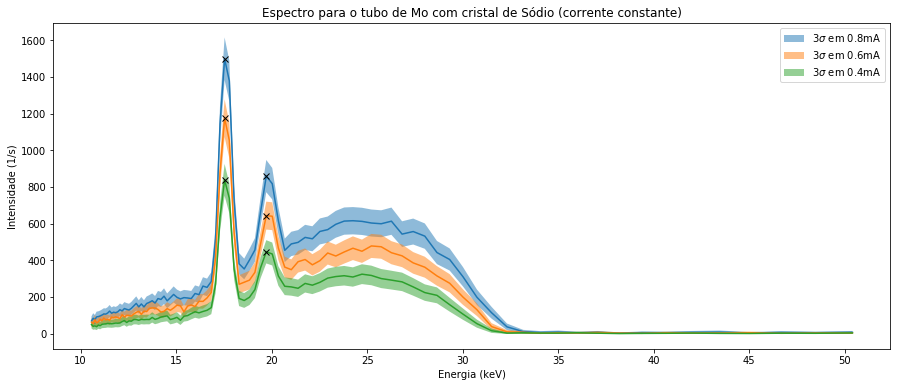

In [39]:
# Fazer o gráfico com incerteza para as medidas e detectar os picos

output = []

for U in columns:
    U_data = data.loc[:, U].copy()    
    U_data.index /= e * 1e3    
    peaks = sig.find_peaks(U_data, prominence=np.mean(U_data), height=np.max(U_data)/2)
    inds = peaks[0]
    neighbor1 = U_data.index[inds - 1]
    neighbor2 = U_data.index[inds + 1]
    L = np.abs(neighbor2 - neighbor1)
    err = L / (np.sqrt(6))
    Uerr = 3 * np.sqrt(U_data.values)
    Uerr_less = U_data - Uerr
    Uerr_more = U_data + Uerr
    plt.plot(U_data, label="")
    plt.plot(U_data.iloc[inds], 'x', label="", color="k")
    plt.fill_between(U_data.index, Uerr_less, Uerr_more, alpha=0.5, label=r"$3 \sigma$ em " + U)
    texto = "I: {}. (Pico: Intensidade) (keV: 1/s) em ".format(U)
    for i, peak in enumerate(U_data.iloc[inds].index):
        intensidade = U_data[peak]
        intensidade = unc.ufloat(intensidade, np.sqrt(intensidade))
        peak_val = unc.ufloat(peak, err[i])
        texto += "({:.2f}: {}), ".format(peak_val, intensidade)
        output.append({"I": peak_val, "N": intensidade})
    print(texto)
plt.xlabel("Energia (keV)")
plt.ylabel("Intensidade (1/s)")
plt.title("Espectro para o tubo de Mo com cristal de Sódio (corrente constante)")
plt.legend()
plt.show()

### Comentários

Pelo resultado, a intensidade de absorção escala linearmente com a corrente aplicada, algo de se esperar, devido a emissão de um único fóton por absorção de elétron pelo Molibênio.